In [1]:
import pandas as pd
import FinanceDataReader as fdr # pip install -U finance-datareader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [2]:
# 데이터 불러오기
# Data Load
start_date = '20200101'
end_date = '20211231'
sample_code = '005930' # 삼성전자, Samsung Electronic
stock = fdr.DataReader(sample_code, start = start_date, end = end_date)
stock = stock[-100:]

In [3]:
stock2 =fdr.DataReader('005380', start = start_date, end = end_date) # 현대차, Hyundai Motor
stock2 = stock2[-100:]

In [4]:
def sigma(ori_list, add_num):
    num = 0
    for i in range(len(ori_list)):
        num += (ori_list[i] + add_num)
    return num

In [5]:
# 논문대로 앞뒤로 한개씩 노이즈 추가하기
# Adding nosie back and front one by one as in the paper
def add_noise(n, price):
    global middle_num 

    middle_num = price.copy()

    for i in range(n):
        x_sigma = sigma(middle_num[:n], 0)
        x_hat1 = (x_sigma/n)**(1/2)
        sigma1 = (sigma(middle_num[:n], -x_hat1)/n)**(1/2)
        front_mean = np.mean(middle_num[:n])
        front_num = np.random.normal(front_mean, sigma1, 1)
        middle_num.insert(0, front_num[0])

        x_sigma = sigma(middle_num[-n:], 0)
        x_hat1 = (x_sigma/n)**(1/2)
        sigma1 = (sigma(middle_num[-n:],-x_hat1)/n)**(1/2)
        end_mean = np.mean(middle_num[-n:])
        end_num = np.random.normal(end_mean, sigma1, 1)
        middle_num.extend(end_num)
   
    return middle_num 

In [6]:
# FFT 적용, Threshold 이하인 값 0으로 만들기 (논문은 0.2임)
# Apply Fourier Transform, Replace value below threshold with 0 (It's 0.2 in the paper)
def convert_to_zero(perc, middle_num):
    global fft 
    fft_signal = np.fft.fft(middle_num)
    fft_signal_abs = np.abs(fft_signal.copy())

    th = perc * (2*fft_signal_abs[0:int(len(middle_num)/2.)]/(len(middle_num)/2.)).max()
    
    fft = fft_signal.copy()
    fft_abs = np.abs(fft)
    fft_abs = 2 * fft_abs / (len(middle_num)/2.)

    fft[fft_abs<=th]=0

    return fft

In [7]:
def mae(ori, test):
    global total_cha
    total_cha = 0
    for i in range(len(ori)):
        cha = abs(ori[i] - test[i])
        total_cha += cha
    total_cha / len(ori)
    return total_cha

In [8]:
mae_list = []
ori_list = []
deno_list = []

ori_price = list(stock2['Close'])
for i in range(1000):
    add_noise(40, ori_price)
    convert_to_zero(0.001, middle_num)

    ifft = np.fft.ifft(fft)
    deno_price = np.real(ifft[40:-40])

    mae(ori_price, deno_price)
    ori_list.append(ori_price)
    deno_list.append(deno_price)
    mae_list.append(total_cha)

In [9]:
print("Max     : " +str(max(mae_list)))
print("Mean    : " + str(sum(mae_list)/len(mae_list)))
print("Min     : " + str(min(mae_list)))

print("Min Idx : " + str(mae_list.index(min(mae_list))))

Max     : 104658.84816739778
Mean    : 97209.69869490719
Min     : 86662.73936234371
Min Idx : 572


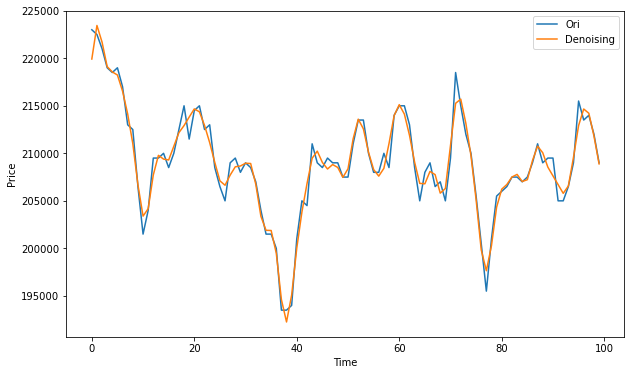

In [10]:
# 원래 값과 디노이징한 값 그래프로 확인
# Check original price and denoised price
plt.figure(figsize = (10,6))
plt.plot(ori_list[572], label = 'Ori')
plt.plot(deno_list[572], label = 'Denoising')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()